# Deep Learning Portfolio 1

|Name|Github|Kaggle|
|----|------|------|
|Mohamed Belaachir|mobelaachir|Mo Belaachir|
|Jayden Debi-Tewari|Jaydendt1|jaydendt123|
|Quincy Soerohardjo|quincysoerohardjo2002|Quincy Soerohardjo|
|Michal Reszka-Gniecki|Ckires|...|

## Table of Contents
- [Data Overview](#data-overview)
- [Exploratory Data Analysis](#exploratory-data-analysis)
    - [Visualiseren](#visualiseren)
- [Feature Engineering](#feature-engineering)
    - [Analysis](#analysis)
- [Modeling](#modeling)
    - [Fully-connected neuraal netwerk](#Model1)
    - [Convolutioneel neuraal netwerk from scratch](#Model2)
    - [Transfer learning](#Model3)
    - [Multimodaal mode](#Model4)
- [Results](#results)
    - [Overview](#overview)
    - [Scores](#scores)
- [Conclusion & Advice](#conclusion--advice)
- [Sources](#sources)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Data Overview

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data importeren

In [5]:
train_numeriek_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Portfolio 1 Datasets/train.csv')
test_numeriek_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Portfolio 1 Datasets/test.csv')

In [6]:
img_train_directory = "/content/drive/MyDrive/Colab Notebooks/Portfolio 1 Datasets/Train"
img_test_directory = "/content/drive/MyDrive/Colab Notebooks/Portfolio 1 Datasets/Test"

## Exploratory Data Analysis

Alle JPEG-afbeeldingen uit de opgegeven map Train en Test worden geladen en opgeslagen in twee lijsten.

In [7]:
image_paths = tf.io.gfile.glob(img_train_directory + '/*.jpg')
train_images = []
for path in image_paths:
    image_raw = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_raw)
    train_images.append(image)

In [8]:
image_paths_test = tf.io.gfile.glob(img_test_directory + '/*.jpg')
test_images = []
for path in image_paths_test:
    image_raw = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_raw)
    test_images.append(image)

Het aantal geladen afbeeldingen in de datasets train_images en test_images wordt weergegeven.

In [9]:
print(f"Aantal geladen afbeeldingen: {len(train_images)}")
print(f"Aantal geladen afbeeldingen: {len(test_images)}")


Aantal geladen afbeeldingen: 500
Aantal geladen afbeeldingen: 35


De vormen (shapes) van de afbeeldingen in de train_images dataset worden geanalyseerd, waarbij alle unieke afbeeldingsformaten worden weergegeven.

In [10]:
image_shapes = [image.shape for image in train_images]
# Om alle unieke shapes te zien:
print(f"Unique shapes : {set(tuple(shape) for shape in image_shapes)}")

Unique shapes : {(1024, 1024, 3)}


De vorm (shape) van de eerste afbeelding in de train_images dataset wordt hiermee weergegeven.

In [11]:
print(f"Image shape: {train_images[0].shape}") # geeft de shape van de eerste image (H, W, C)
# het laatste getal in de shape is het aantal kleurkanalen

Image shape: (1024, 1024, 3)


## Voorbeeld van trainings- en testafbeeldingen

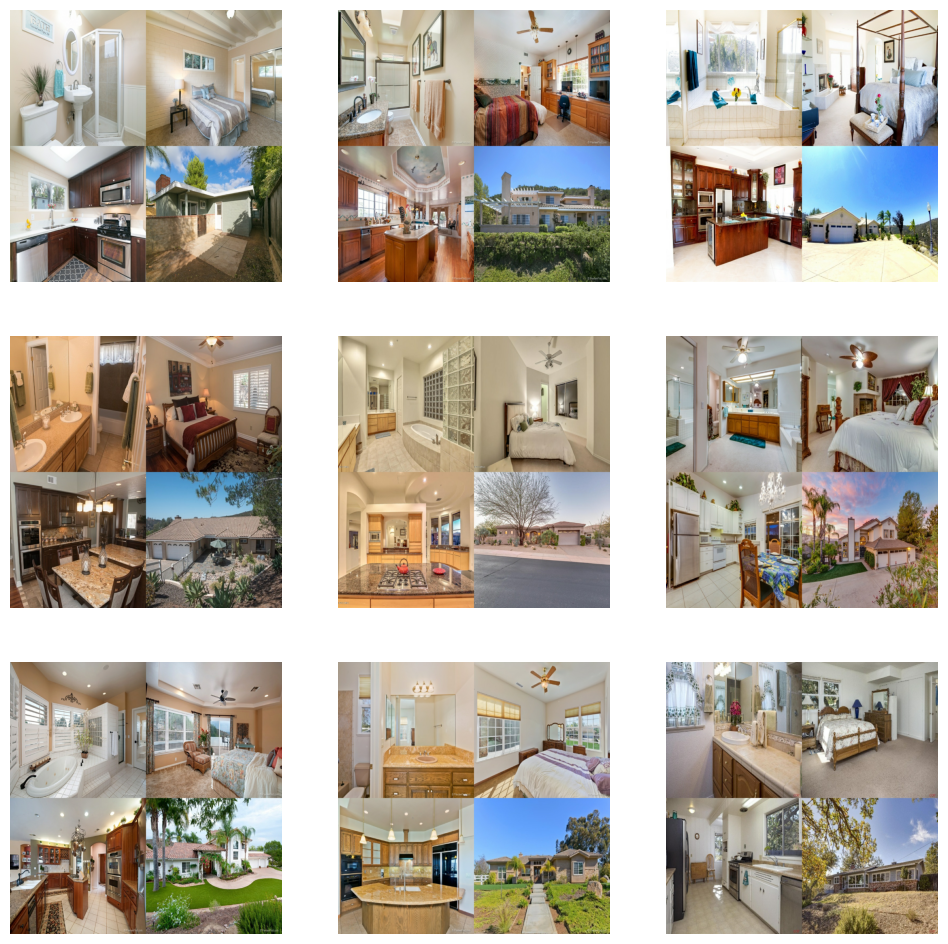

In [12]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[i].numpy())
    plt.axis("off")
plt.show()

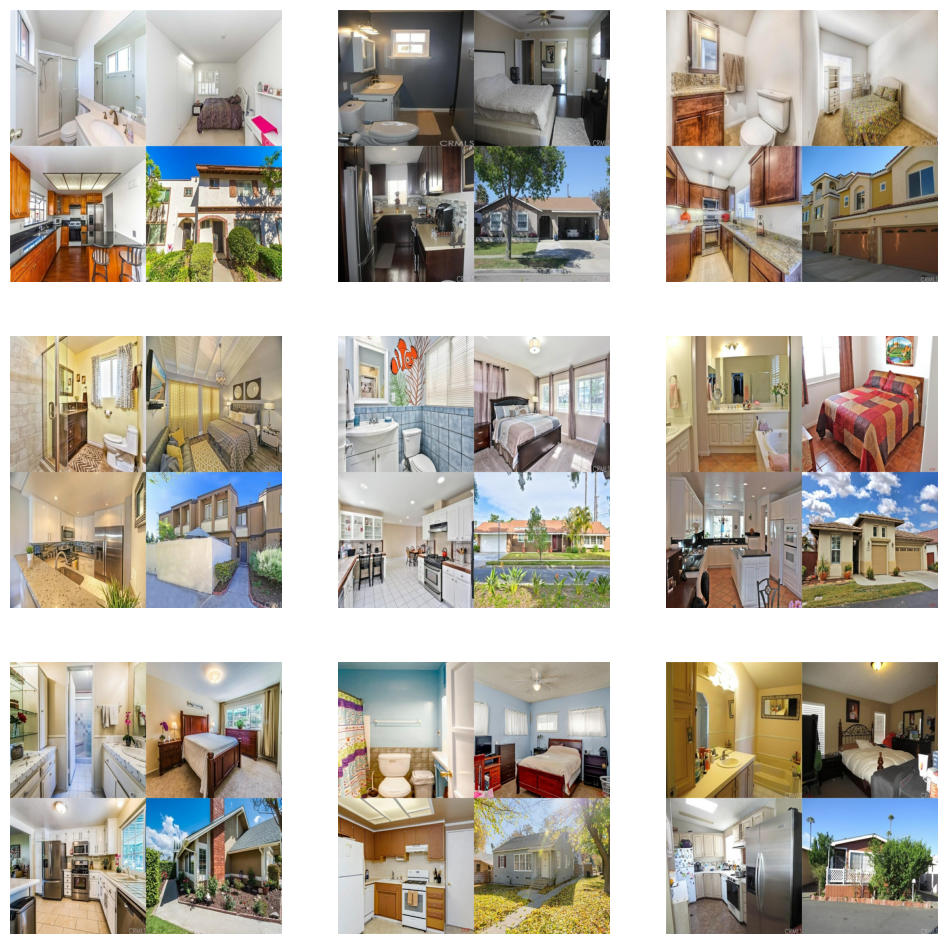

In [13]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i].numpy())
    plt.axis("off")
plt.show()

De grafiek toont de verdeling van pixelwaarden voor de kleuren rood, groen en blauw in de afbeeldingen.

Mean pixel values: [142.74492561 133.55400624 119.70312065]


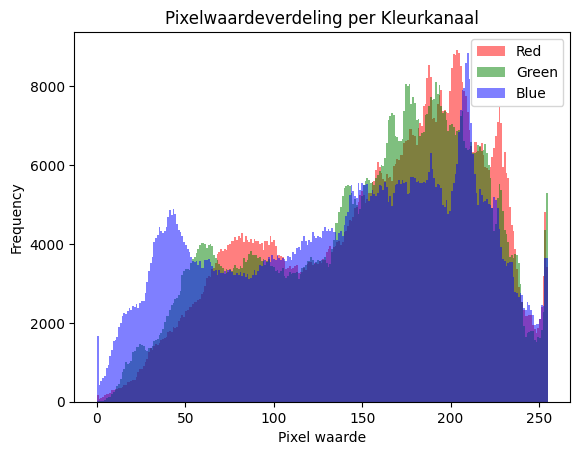

In [14]:
# Converteer images naar NumPy arrays
image_arrays = [image.numpy() for image in train_images]

# Bereken de gemiddelde pixelwaarde per kanaal
mean_pixel_values = np.mean(image_arrays, axis=(0, 1, 2))
print(f"Mean pixel values: {mean_pixel_values}")

# Plot histogrammen van pixelwaarden per kanaal
plt.hist(image_arrays[0][:, :, 0].flatten(), bins=256, color='red', alpha=0.5, label='Red')
plt.hist(image_arrays[0][:, :, 1].flatten(), bins=256, color='green', alpha=0.5, label='Green')
plt.hist(image_arrays[0][:, :, 2].flatten(), bins=256, color='blue', alpha=0.5, label='Blue')
plt.legend()
plt.title('Pixelwaardeverdeling per Kleurkanaal')
plt.xlabel('Pixel waarde')
plt.ylabel('Frequency')
plt.show()

De x-as vertegenwoordigt de pixelwaarden, die variëren van 0 tot 250, en de y-as geeft het aantal pixels weer voor elke waarde.

Uit de grafiek kunnen we afleiden hoe de intensiteit van elke kleur is verdeeld over de afbeelding. Als een bepaalde kleur een hogere piek heeft bij specifieke pixelwaarden, betekent dit dat die kleurintensiteit vaker voorkomt in de afbeeldingen.

De rode piek is het hoogst, gevolgd door groen en daarna blauw. Dit kan helpen om de kleurbalans en de algemene toon van de afbeelding te begrijpen. Een dominante rode piek kan wijzen op een warmere kleurtemperatuur in de afbeelding
.

In [15]:
display(train_numeriek_df.head())
display(test_numeriek_df.head())

House ID  Bedrooms  Bathrooms  Area  Latitude  Longitude   Price
0         1         4        4.0  4053   33.6968  -111.8892  869500
1         2         4        3.0  3343   34.8280  -119.0349  865200
2         3         3        4.0  3923   33.7669  -111.9182  889000
3         4         5        5.0  4022   33.7752  -111.7791  910000
4         5         3        4.0  4116   33.7669  -111.9182  971226

House ID  Bedrooms  Bathrooms  Area  Latitude  Longitude
0       501         3        2.0  2330   35.6406  -120.7003
1       502         3        2.5  1339   35.6406  -120.7003
2       503         3        2.0  1472   35.6406  -120.7003
3       504         4        4.0  2681   35.6406  -120.7003
4       505         3        2.5  1935   33.8085  -117.9228

###Datatype

In [16]:
train_numeriek_df.info()
test_numeriek_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   500 non-null    int64  
 1   Bedrooms   500 non-null    int64  
 2   Bathrooms  500 non-null    float64
 3   Area       500 non-null    int64  
 4   Latitude   500 non-null    float64
 5   Longitude  500 non-null    float64
 6   Price      500 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 27.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   35 non-null     int64  
 1   Bedrooms   35 non-null     int64  
 2   Bathrooms  35 non-null     float64
 3   Area       35 non-null     int64  
 4   Latitude   35 non-null     float64
 5   Longitude  35 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 1.8 KB


### Kolombeschrijving

**House ID**: Unieke ID voor elk huis (int)  
**Bedrooms**: Het aantal slaapkamers in een huis (int)  
**Bathrooms**: Het aantal badkamers in een huis. Een halve badkamer betekent dan alleen 1 toilet of doucheruimte of wasbak. (float)  
**Area**: Het totale oppervlakte van het huis  
**Latitude**: Coordinaten (float)    
**Latitude**: Coordinaten (float)  
**Price**: De prijs van het huis (int)

### Verdeling van de data

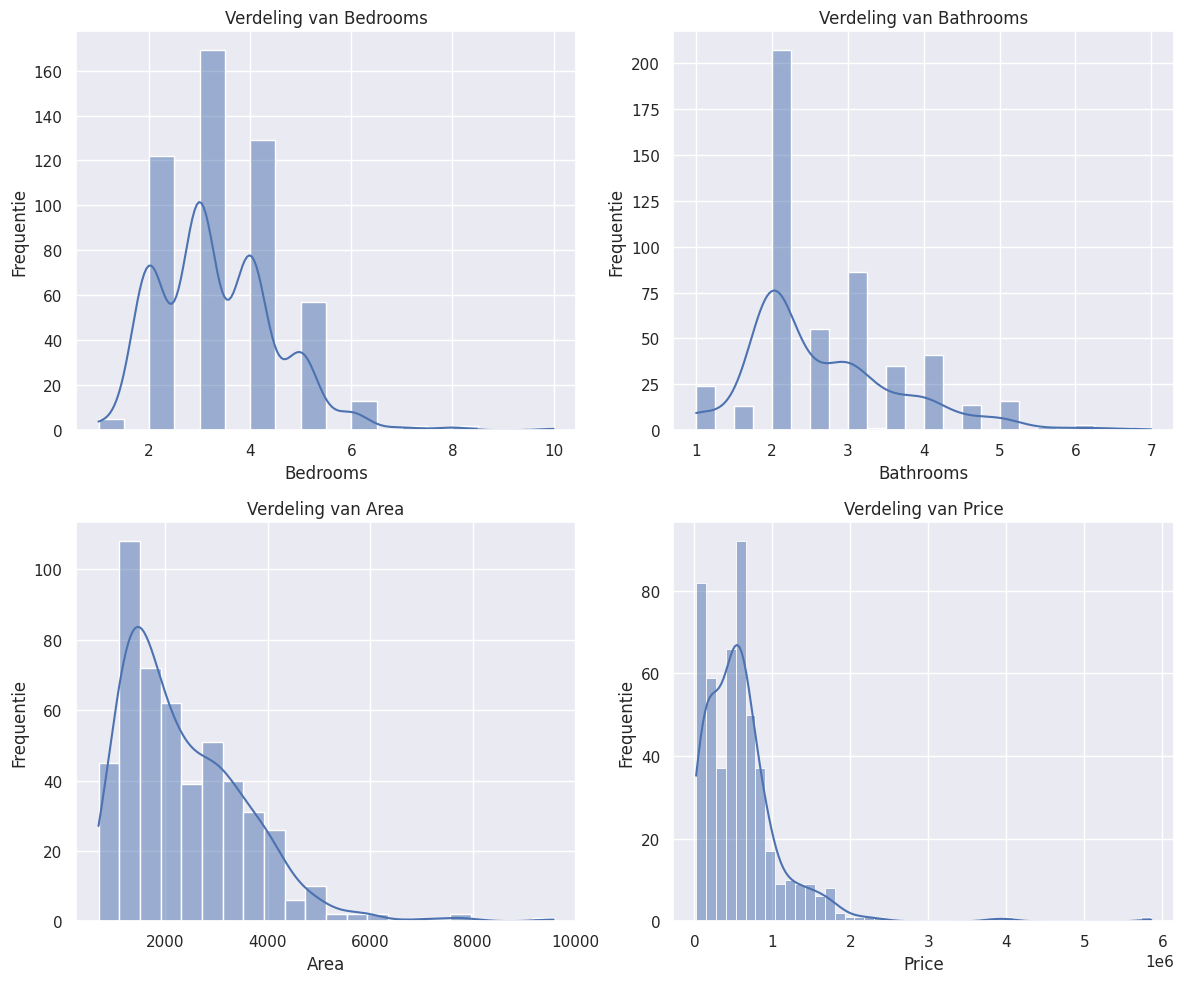

In [17]:
kolommen = ['Bedrooms', 'Bathrooms', 'Area', 'Price']

sns.set(style="darkgrid")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rijen, 2 kolommen

# Histogrammen plotten in het raster
ax_index = 0
for rij in range(2):
    for kolom in range(2):
        sns.histplot(train_numeriek_df[kolommen[ax_index]], kde=True, ax=axes[rij, kolom])
        axes[rij, kolom].set_title(f'Verdeling van {kolommen[ax_index]}')
        axes[rij, kolom].set_xlabel(kolommen[ax_index])
        axes[rij, kolom].set_ylabel('Frequentie')
        ax_index += 1

plt.tight_layout()  # Ruimte tussen subplots aanpassen
plt.show()

# Er zijn halve waardes bij bathrooms. Die zijn dan misschien alleen toiletten of wasbakken

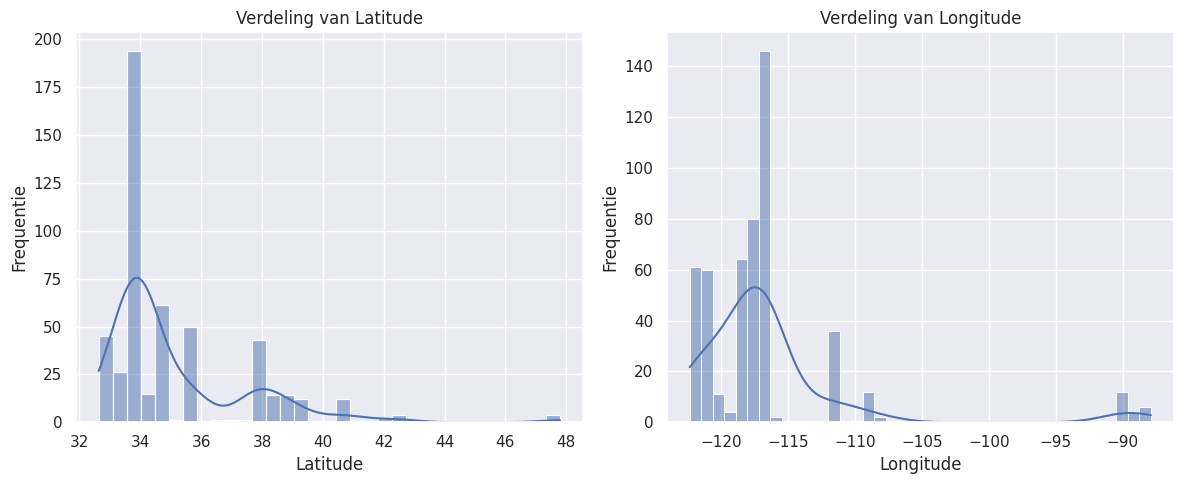

In [18]:
# Plot histogram voor longtitude en latitude
sns.set(style="darkgrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 rij, 2 kolommen

# Histogrammen plotten in het raster
ax_index = 0
for kolom in ['Latitude', 'Longitude']:
    sns.histplot(train_numeriek_df[kolom], kde=True, ax=axes[ax_index])
    axes[ax_index].set_title(f'Verdeling van {kolom}')
    axes[ax_index].set_xlabel(kolom)
    axes[ax_index].set_ylabel('Frequentie')
    ax_index += 1

plt.tight_layout()  # Ruimte tussen subplots aanpassen
plt.show()

### Correlaties

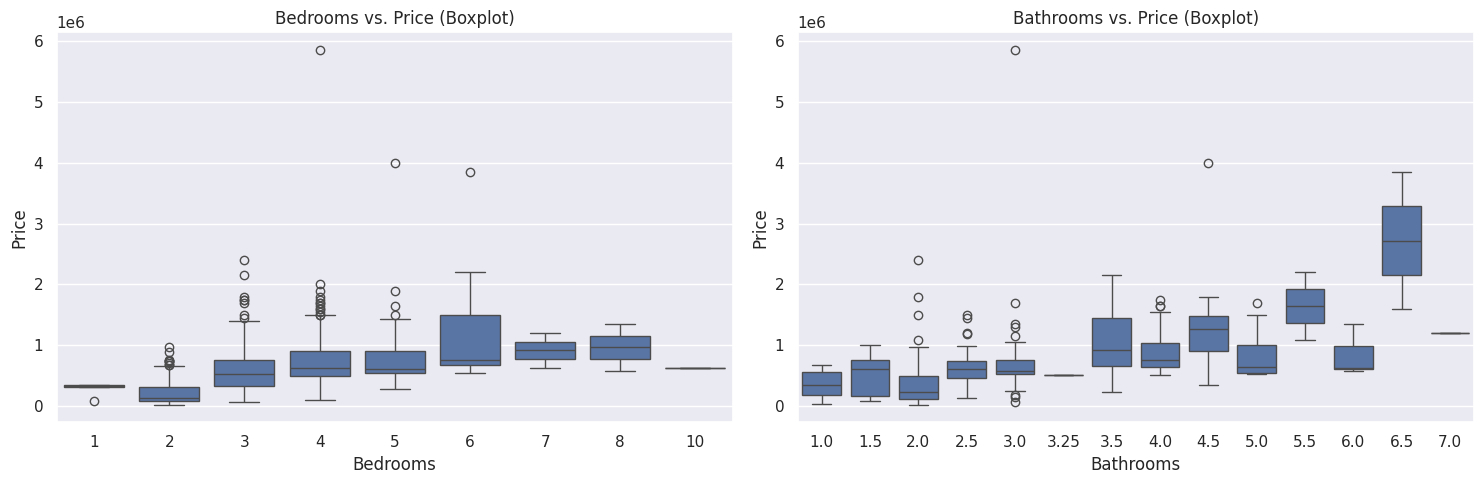

In [19]:
kolommen = ['Bedrooms', 'Bathrooms']

fig, axes = plt.subplots(1, len(kolommen), figsize=(15, 5))

# Boxplots plotten
for i, kolom in enumerate(kolommen):
    sns.boxplot(x=kolom, y='Price', data=train_numeriek_df, ax=axes[i])
    axes[i].set_title(f'{kolom} vs. Price (Boxplot)')
    axes[i].set_xlabel(kolom)
    axes[i].set_ylabel('Price')

plt.tight_layout()
plt.show()

#### Bevindingen

**Bedrooms**: Er zit geen sterke lineare verband in deze grafiek. Het blijkt dat huizen met slaapkamers van 1 tot 6 wel een lineare correlatie hebben, maar na 6 slaapkamers verschillen de prijzen niet meer.  
**Bathrooms**: Er blijkt geen lineare verband te zijn in deze grafiek. Maar er is wel te zien dat "halve" badkamers een hogere prijs hebben vergeleken met alleen complete badkamers.  

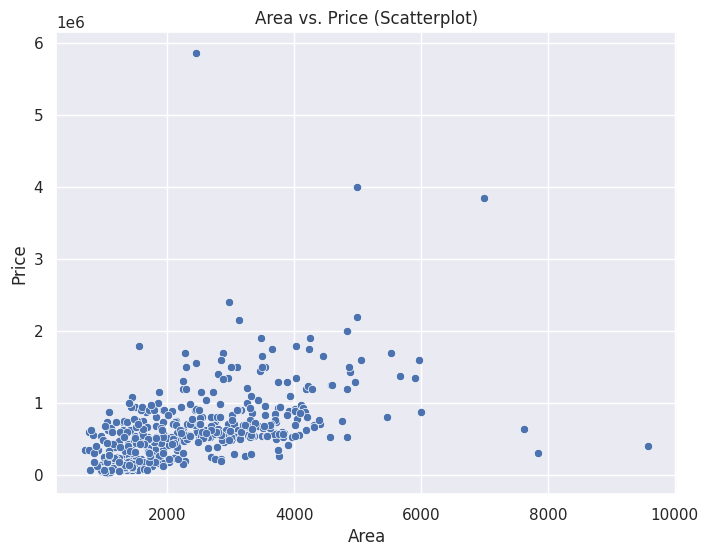

In [20]:

plt.figure(figsize=(8, 6))
sns.scatterplot(x='Area', y='Price', data=train_numeriek_df)
plt.title('Area vs. Price (Scatterplot)')
plt.xlabel('Area')
plt.ylabel('Price')
plt.show()

**Area**: In deze grafiek is er wel een relatief linear verband. Het blijkt dat huizen met een grotere oppervlakte wel duurder zijn.

### Conclusie  
Over het algemeen lijkt woonoppervlakte de sterkste invloed te hebben op de huisprijs, terwijl het effect van slaapkamers en badkamers niet zo duidelijk is.

### Visualiseren

## Feature Engineering

In [21]:
# Wijzig de vorm van alle afbeeldingen na de lus
resized_train_images = []
for image in train_images:
    resized_image = tf.image.resize(image, (224, 224))  # Wijzig de gewenste vorm
    resized_train_images.append(resized_image)

### Data Preparation

In [22]:
# Removing House ID, Longtitude and Altitude
train_numeriek_df_clean = train_numeriek_df.drop(['House ID', 'Longitude', 'Latitude'], axis=1)
test_numeriek_df_clean = test_numeriek_df.drop(['House ID', 'Longitude', 'Latitude'], axis=1)

#### Normalize

In [23]:
# Normaliseer de hele dataset met MinMaxScaler
scaler = MinMaxScaler()
train_numeriek_df_clean = pd.DataFrame(scaler.fit_transform(train_numeriek_df_clean), columns=train_numeriek_df_clean.columns)
display(train_numeriek_df_clean)



Bedrooms  Bathrooms      Area     Price
0    0.333333   0.500000  0.377392  0.145219
1    0.333333   0.333333  0.297456  0.144483
2    0.222222   0.500000  0.362756  0.148561
3    0.444444   0.666667  0.373902  0.152159
4    0.222222   0.500000  0.384485  0.162650
..        ...        ...       ...       ...
495  0.111111   0.166667  0.062599  0.061343
496  0.333333   0.166667  0.154357  0.069894
497  0.111111   0.166667  0.170232  0.096470
498  0.222222   0.250000  0.089957  0.050891
499  0.333333   0.500000  0.258838  0.252399

[500 rows x 4 columns]

### Analysis

## Modeling

In [24]:
X = train_numeriek_df_clean.drop('Price', axis=1)
y = train_numeriek_df_clean['Price']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(train_numeriek_df_clean.shape[1]-1,)), # Input layer met 64 neuronen en ReLU activatie. -1 omdat price niet meegenomen moet worden.
    layers.Dense(32, activation='relu'), # Hidden layer met 32 neuronen en ReLU activatie.
    layers.Dense(1) # Output layer met 1 neuron voor de prijsvoorspelling.
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [27]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [28]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

# Evaluate
test_loss, test_mae = model.evaluate(X_val, y_val)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 413ms/step - loss: 0.0133 - mae: 0.0781 - val_loss: 0.0053 - val_mae: 0.0619
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0074 - mae: 0.0633 - val_loss: 0.0033 - val_mae: 0.0439
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063 - mae: 0.0468 - val_loss: 0.0032 - val_mae: 0.0459
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - mae: 0.0486 - val_loss: 0.0032 - val_mae: 0.0456
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mae: 0.0455 - val_loss: 0.0030 - val_mae: 0.0443
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0051 - mae: 0.0487 - val_loss: 0.0030 - val_mae: 0.0446
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - mae: 0.0459 - val_loss: 0.0029 - val_mae: 0.0437
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072 - mae: 0.0507 - val_loss: 0.0029 - val_mae: 0.0436
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

In [29]:
# Bereken de MAPE
y_pred = model.predict(X_val)
mape = mean_absolute_percentage_error(y_val, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Mean Absolute Percentage Error (MAPE): 179.89%


### Fully-connected neuraal netwerk

### Convolutioneel neuraal netwerk from scratch

Een Convolutioneel Neuraal Netwerk (CNN) is een speciaal type neuraal netwerk dat vooral wordt gebruikt voor het verwerken van afbeeldingen. CNN's zijn goed in taken zoals het herkennen van objecten en het classificeren van beelden. Ze werken door patronen in een afbeelding te zoeken met behulp van wiskundige berekeningen, zoals convoluties. Hierdoor kunnen ze vormen, randen en structuren herkennen, wat belangrijk is voor computer vision-toepassingen zoals gezichtsherkenning en zelfrijdende auto's.

[(Torres, 2023)](https://medium.com/latinxinai/convolutional-neural-network-from-scratch-6b1c856e1c07)


#### Basisprincipes van CNN's


##### 1. Convolutie Laag (Convolution Layer)


De convolutielaag is een belangrijk onderdeel van een CNN. Het gebruikt een klein filter (ook wel kernel genoemd) om een afbeelding te analyseren en belangrijke kenmerken te herkennen.

- Filter: Een klein raster (bijvoorbeeld 3×3) dat over de afbeelding beweegt.

- Stapgrootte (Stride): Het aantal pixels dat het filter per keer opschuift.

- Padding: Extra pixels aan de randen van de afbeelding toevoegen om de afmetingen van de uitvoer te behouden.

[(Torres, 2023)](https://medium.com/latinxinai/convolutional-neural-network-from-scratch-6b1c856e1c07)

[(GeeksforGeeks, 2024b)](https://www.geeksforgeeks.org/introduction-convolution-neural-network/
)


**Berekening:** Op elke positie wordt het filter vermenigvuldigd met het bijbehorende deel van de afbeelding. Daarna worden de resultaten opgeteld om een nieuw beeld te vormen.

##### 2. Pooling Laag (Pooling Layer)

Pooling is een techniek die helpt om de hoeveelheid gegevens in een afbeelding te verkleinen. Dit maakt het model sneller en minder gevoelig voor kleine veranderingen in de afbeelding.

- Max Pooling: Kiest de hoogste waarde in een klein gebied van de afbeelding.

- Average Pooling: Berekent het gemiddelde van de waarden in een klein gebied.

[(Torres, 2023)](https://medium.com/latinxinai/convolutional-neural-network-from-scratch-6b1c856e1c07)

##### 3. Activatiefunctie (Activation Function)

Een activatiefunctie zorgt ervoor dat een neuraal netwerk complexe patronen kan leren door niet-lineariteit toe te voegen. Een veelgebruikte activatiefunctie is ReLU (Rectified Linear Unit), die negatieve waarden naar nul omzet en positieve waarden doorlaat.


[(GeeksforGeeks, 2024b)](https://www.geeksforgeeks.org/introduction-convolution-neural-network/)


##### 4. Fully Connected Layer (Volledig verbonden laag)

Deze laag zorgt voor de classificatie op basis van de kenmerken die in de vorige lagen zijn gevonden. Terwijl convolutie- en poolinglagen vaak de ReLU-activeringsfunctie gebruiken, maakt de volledig verbonden laag (fully connected layer) gebruik van de Softmax-functie. Deze functie zet de uitkomsten om in waarschijnlijkheden tussen 0 en 1, zodat het netwerk kan voorspellen tot welke klasse een invoer behoort.


[(Torres, 2023)](https://medium.com/latinxinai/convolutional-neural-network-from-scratch-6b1c856e1c07)


[(IBM. (z.d.))](https://www.ibm.com/think/topics/convolutional-neural-networks)

#### Regularisatie in Convolutionele Neurale Netwerken


**L1-regularisatie (Lasso):** Hierbij wordt de absolute waarde van de gewichten opgeteld bij de verliesfunctie. Dit zorgt ervoor dat sommige gewichten precies nul worden, waardoor minder belangrijke parameters verdwijnen. Het resultaat is een eenvoudiger model met minder filters.

$$
\text{Loss} = \text{lossfunctie} + \lambda \sum |β_i|
$$

**L2-regularisatie (Ridge, Weight Decay):** Deze methode telt de kwadraten van de gewichten op bij de verliesfunctie. Hierdoor blijven de gewichten klein en worden extreme waarden voorkomen. Dit helpt het model stabieler en minder gevoelig voor overfitting te maken.

$$
\text{Loss} = \text{lossfunctie} + \lambda \sum β_i^2
$$


[(Tewari, 2024)](https://medium.com/analytics-vidhya/regularization-understanding-l1-and-l2-regularization-for-deep-learning-a7b9e4a409bf)



**Dropout** is een techniek om overfitting te voorkomen in diepe neurale netwerken. Tijdens het trainen worden willekeurig sommige uitgangen van een laag genegeerd ("dropout"). Hierdoor leert het model minder afhankelijk te zijn van specifieke neuronen en wordt het robuuster.

[(GeeksforGeeks, 2024a)](https://www.geeksforgeeks.org/dropout-regularization-in-deep-learning/
)


Batch normalisatie zorgt ervoor dat een CNN sneller en stabieler traint door de activaties per batch te normaliseren. Dit voorkomt dat waarden te groot of te klein worden en helpt het netwerk beter om te gaan met variaties in de invoerdata. Hierdoor kan het model efficiënter leren.



[(Wikipedia contributors, 2024b)](https://en.wikipedia.org/wiki/Batch_normalization#:~:text=December%202021),and%20Christian%20Szegedy%20in%202015.)

Data-augmentatie is een manier om overfitting te verminderen bij CNN’s. Door de trainingsdata te variëren met technieken zoals roteren, schalen, spiegelen en vervormen, leert het model robuustere en algemenere kenmerken. Dit helpt het netwerk beter om te gaan met nieuwe, onbekende afbeeldingen.

[(IBM. (z.d.))](https://www.ibm.com/think/topics/data-augmentation)


#### Hoe kies je de beste regularisatie?

De keuze voor regularisatie hangt af van het doel van je model. L1-regularisatie is handig als je een eenvoudiger model met minder parameters wilt, terwijl L2-regularisatie beter is als je alle features wilt behouden maar hun invloed wilt beperken. Data-augmentatie is vooral nuttig bij beeldherkenning en deep learning, omdat het variatie in de trainingsdata toevoegt en zo de generalisatie verbetert. Dropout werkt goed in diepe neurale netwerken, vooral bij grote modellen, omdat het willekeurig neuronen uitschakelt tijdens training en zo overfitting tegengaat.

[(Olamendy, 2024)](https://medium.com/@juanc.olamendy/a-comprehensive-guide-to-regularization-in-machine-learning-9d1243002c50)

Een kolom 'filename' wordt toegevoegd aan de DataFrame train_numeriek_df, waarin het bestandspad van elke afbeelding wordt gegenereerd op basis van de 'House ID'.

In [ ]:
# Genereert een nieuwe kolom 'filename'
train_numeriek_df['filename'] = train_numeriek_df['House ID'].apply(lambda x: f"{img_train_directory}/{x}.jpg")

# Controleer of de bestanden bestaan
invalid_files = []
for file_path in train_numeriek_df['filename']:
    if not os.path.exists(file_path):
        invalid_files.append(file_path)

if invalid_files:
    print(f"Aantal ongeldige bestanden: {len(invalid_files)}")
    print("Voorbeelden van ongeldige bestanden:", invalid_files[:5])
else:
    print("Alle bestanden zijn geldig.")


Alle bestanden zijn geldig.


De dataset train_numeriek_df wordt opgesplitst in een trainingset (80%) en een validatieset (20%), waarbij random_state=42 zorgt voor reproduceerbaarheid.

In [ ]:
# Split in train/validation
train_df = train_numeriek_df.sample(frac=0.8, random_state=42)
val_df = train_numeriek_df.drop(train_df.index)


De prijzen in zowel de trainings- als validatieset worden genormaliseerd door elke waarde te delen door de maximale prijs in de dataset.

In [ ]:
train_df['Price'] = train_df['Price'] / train_df['Price'].max()
val_df['Price'] = val_df['Price'] / val_df['Price'].max()

Een data-augmentatiepipeline wordt ingesteld voor de trainingsset, waarbij afbeeldingen worden geschaald en willekeurig getransformeerd. De validatieset wordt alleen geschaald. Vervolgens worden generators aangemaakt om de afbeeldingen en bijbehorende prijzen in batches te laden voor modeltraining.

In [ ]:
# Data augmentation voor training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    zoom_range=0.2
)

# Alleen rescaling voor validatie
val_datagen = ImageDataGenerator(rescale=1./255)


# Train generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='Price',
    target_size=(256, 256),
    class_mode='raw',
    batch_size=32,
    shuffle=True  # ✅ Zorg dat de batches worden geschud
)

# Validation generator
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='Price',
    target_size=(256, 256),
    class_mode='raw',
    batch_size=32,
    shuffle=False  #
)


Found 400 validated image filenames.
Found 100 validated image filenames.


In [ ]:
# Definieer het CNN-model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),  # Dropout voor regularisatie
    Dense(1)  # Output laag voor regressie
])

# Compileer het model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',  # Gebruik MSE voor regressie
              metrics=['mae'])  # Mean Absolute Error als metriek

# Early Stopping om overfitting te voorkomen
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Samenvatting van het model
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │      25,690,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,079,553 (99.49 MB)

 Trainable params: 26,079,553 (99.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train het model
history = model.fit(
    train_generator,
    epochs=10,  # Aantal epochs, kan aangepast worden
    validation_data=validation_generator,
    callbacks=[early_stopping],  # Gebruik EarlyStopping om overfitting te voorkomen
    verbose=1
)

# Evalueer het model op de validatiedata
loss, mae = model.evaluate(validation_generator)
print(f"Validation Loss (MSE): {loss}")
print(f"Validation MAE: {mae}")

# Voorspel de waarden voor de validatiedata
y_pred = model.predict(validation_generator)
y_true = validation_generator.labels

# Bereken MAPE handmatig
mape = np.mean(np.abs((y_true - y_pred.flatten()) / y_true)) * 100
print(f"Validation MAPE: {mape:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 9.6996 - mae: 1.1219 - val_loss: 0.8157 - val_mae: 0.2408
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 985ms/step - loss: 0.7186 - mae: 0.0669 - val_loss: 0.7101 - val_mae: 0.1828
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 985ms/step - loss: 0.6336 - mae: 0.0668 - val_loss: 0.6404 - val_mae: 0.1857
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 984ms/step - loss: 0.5750 - mae: 0.0761 - val_loss: 0.6016 - val_mae: 0.2025
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 979ms/step - loss: 0.5287 - mae: 0.0670 - val_loss: 0.5828 - val_mae: 0.2274
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 978ms/step - loss: 0.4958 - mae: 0.0652 - val_loss: 0.5471 - val_mae: 0.2095
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 993ms/step - loss: 0.4696 - mae: 0.0591 - val_loss: 0.5177 - val_mae: 0.1934
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 986ms/step - loss: 0.4516 - mae: 0.0623 - val_loss: 0.4995 - val_mae: 0.1909
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 988ms/ste


### Transfer learning

Transfer learning is een machine learning-techniek waarbij een model dat eerder is getraind op een specifieke taak, wordt hergebruikt als basis voor een tweede, gerelateerde taak. Dit is vooral nuttig wanneer er beperkte data beschikbaar is voor de nieuwe taak, omdat het model al algemene kenmerken heeft geleerd die toepasbaar zijn op meerdere taken. Doordat het model tijdens de initiële training kennis heeft opgedaan uit een grote dataset, kan het sneller en efficiënter worden aangepast aan de nieuwe taak (GeeksforGeeks, z.d.).  

**Bron**  
GeeksforGeeks. (z.d.). *ML | Introduction to Transfer Learning*. GeeksforGeeks. [https://www.geeksforgeeks.org/ml-introduction-to-transfer-learning/](https://www.geeksforgeeks.org/ml-introduction-to-transfer-learning/)  


##Modelkeuze en Pretraining

Voor deze opdracht heb ik gebruikgemaakt van ResNet50 als vooraf getraind computervisiemodel. Dit model is vooraf getraind op de ImageNet-dataset, een grootschalige dataset met miljoenen afbeeldingen verspreid over 1000 klassen.

Voordelen van vooraf getrainde visionmodellen:

Snellere convergentie: Omdat het model al patronen heeft geleerd uit een grote dataset, is er minder trainingstijd nodig.

Betere generalisatie: Het model heeft al veelvoorkomende kenmerken zoals randen, texturen en objectvormen geleerd.

Minder data nodig: Transfer learning werkt goed met kleinere datasets, omdat het model al goede feature-extracties kan uitvoeren.

Efficiënt gebruik van rekenkracht: Het hergebruiken van een bestaand model bespaart computationele kosten vergeleken met het trainen van een model vanaf nul.

In [30]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential


# Convert to numpy arrays

X_images = np.array(resized_train_images)
y_prices = train_numeriek_df_clean['Price'].values

# Create TensorFlow Dataset

def create_dataset(images, prices, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, prices))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images))
    return dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)


# Split into train/validation (80/20)
split = int(0.8 * len(X_images))
train_ds = create_dataset(X_images[:split], y_prices[:split])
val_ds = create_dataset(X_images[split:], y_prices[split:])



##Modelarchitectuur en Visualisatie

Voor het bouwen van het model heb ik de volgende stappen doorlopen:

**Data Augmentatie:**

RandomFlip: Willekeurige horizontale spiegeling om variatie in de dataset te vergroten.

RandomRotation (0.2): Willekeurige rotatie om het model robuuster te maken.
__________


**Preprocessing:**

Lambda Layer om de afbeeldingen te preprocessen met de ImageNet normalisatie.

Gebruik van ResNet50 als basis:

Input shape: (224, 224, 3)

Base model zonder top layers (feature-extractor modus).

Bevroren gewichten in de beginfase om eerdere kennis te behouden.
_____
**Custom Layers toegevoegd voor fine-tuning:**

-GlobalAveragePooling2D(): Reduceert de feature map tot een enkele vector.

-Dense(512, relu) + Dropout(0.3): Voegt non-lineariteit en voorkomt overfitting.

-Dense(128, relu) + Dropout(0.2): Extra non-lineariteit en regularisatie.

-Dense(1): Uitgangslaag voor regressie.

In [ ]:
#  Model Construction
base_model = ResNet50(weights='imagenet',
                     include_top=False,
                     input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

preprocess_input = tf.keras.applications.resnet50.preprocess_input

model = Sequential([
    layers.Input(shape=(224, 224, 3)),

    # Light data augmentation
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),

     # Preprocessing
    layers.Lambda(preprocess_input),

    # Base model
    base_model,

    # Feature extraction
    layers.GlobalAveragePooling2D(),

    # Regression head
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1),  # Single output for regression
])

# . Model Compilation
base_learning_rate = 0.001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss='mse',  # Mean Squared Error for regression
    metrics=['mae', 'mape']  # Mean Absolute Error & Percentage Error
)

# . Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

# . Model Training
initial_epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs,
    callbacks=[early_stopping]
)





Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 470ms/step - loss: 7.9701 - mae: 1.9400 - mape: 2218391.5000 - val_loss: 0.4156 - val_mae: 0.6176 - val_mape: 1651.4622
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 0.6554 - mae: 0.6652 - mape: 1355677.7500 - val_loss: 0.1705 - val_mae: 0.3818 - val_mape: 900.1023
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - loss: 0.2028 - mae: 0.3498 - mape: 49095.9062 - val_loss: 0.0166 - val_mae: 0.0774 - val_mape: 246.1659
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.1083 - mae: 0.2686 - mape: 798899.1875 - val_loss: 0.0196 - val_mae: 0.1030 - val_mape: 415.7502
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - loss: 0.0821 - mae: 0.2302 - mape: 615098.5000 - val_loss: 0.0134 - val_mae: 0.0640 - val_mape: 253.3729
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - loss: 0.0406 - mae: 0.1605 - mape: 321590.9375 - val_loss: 0.0156 - val_mae: 0.0804 - val_mape: 334.8677
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 18

##Fine-tuning Stappen

Na de initiële training heb ik fine-tuning toegepast:

Unfreezing van ResNet50:

De eerste 80 lagen blijven bevroren, zodat de vroege kenmerken behouden blijven.

De resterende lagen zijn trainbaar gemaakt om domeinspecifieke kenmerken te leren.

Number of layers in the base model:  175


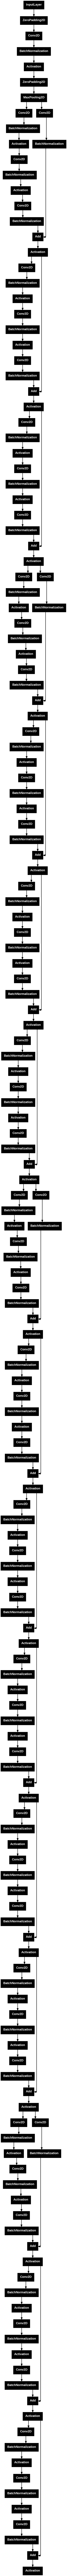

In [ ]:
#  Fine-tuning
# Unfreeze some layers for fine-tuning
base_model.trainable = True
# Check to see how many layers there are
print("Number of layers in the base model: ", len(base_model.layers))
from tensorflow.keras.utils import plot_model

plot_model(base_model)


Epoch 9/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 579ms/step - loss: 0.0428 - mae: 0.1589 - mape: 1201546.6250 - val_loss: 0.0134 - val_mae: 0.0727 - val_mape: 282.5865
Epoch 10/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 307ms/step - loss: 0.0536 - mae: 0.1713 - mape: 290192.7812 - val_loss: 0.0136 - val_mae: 0.0745 - val_mape: 289.1504
Epoch 11/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 346ms/step - loss: 0.0458 - mae: 0.1609 - mape: 1635519.0000 - val_loss: 0.0138 - val_mae: 0.0759 - val_mape: 294.7525
Epoch 12/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 331ms/step - loss: 0.0389 - mae: 0.1510 - mape: 482600.9688 - val_loss: 0.0140 - val_mae: 0.0772 - val_mape: 299.5172
Epoch 13/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - loss: 0.0487 - mae: 0.1692 - mape: 2244528.5000 - val_loss: 0.0141 - val_mae: 0.0778 - val_mape: 301.7764
Epoch 14/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 340ms/step - loss: 0.0480 - mae: 0.1563 - mape: 734187.0625 - val_loss: 0.0143 - val_mae: 0.0794 - val_mape: 308.7074
Epoch 15/40
13/13 ━━━━━━━━━━━━━━━━━━━

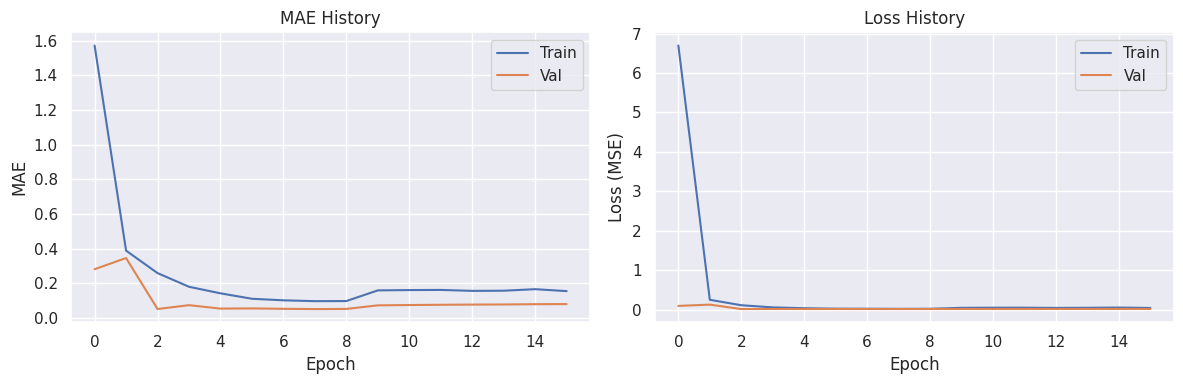

In [ ]:
# Freeze first 80 layers
for layer in base_model.layers[:80]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/1000),
    loss='mse',
    metrics=['mae', 'mape']  # Mean Absolute Error and Mean Absolute Percentage Error
)

# Fine-tuning training
fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=[early_stopping]
)

# Comprehensive evaluation
val_loss, val_mae, val_mape = model.evaluate(val_ds)

print("\nFinal Evaluation Metrics:")
print(f"Validation MSE: {val_loss:.4f}")
print(f"Validation MAE: {val_mae:.4f}")
print(f"Validation MAPE: {val_mape:.2f}%")

# Additional diagnostic plots
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'] + history_fine.history['mae'])
plt.plot(history.history['val_mae'] + history_fine.history['val_mae'])
plt.title('MAE History')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'])
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'])
plt.title('Loss History')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.tight_layout()
plt.show()



TensorFlow Guide - Transfer Learning:

TensorFlow. (n.d.). Transfer learning with tf.keras. TensorFlow. Geraadpleegd op 26 maart 2025, van https://www.tensorflow.org/tutorials/images/transfer_learning

ResNet50 en Pretrained Models:

Keras. (n.d.). ResNet50 model. Keras. Geraadpleegd op 26 maart 2025, van https://keras.io/api/applications/resnet/#resnet50-function

In [ ]:
from tensorflow.keras.regularizers import l2

# Unfreeze de laatste lagen van ResNet50
base_model.trainable = True
for layer in base_model.layers[:80]:
    layer.trainable = False

# Recompile met een nog lagere learning rate
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=base_learning_rate/100),
    loss='mse',
    metrics=['mae', 'mape']
)

# Fine-tune training met verhoogde dropout en L2 regularisatie
model.pop()  # Verwijder de laatste Dense laag
model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(layers.Dropout(0.3))  # Dropout verhoogd
model.add(layers.Dense(1))

# Train opnieuw met fine-tuning
fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=[early_stopping]
)

# Evaluatie
val_loss, val_mae, val_mape = model.evaluate(val_ds)

print("\nFinal Evaluation Metrics:")
print(f"Validation MSE: {val_loss:.4f}")
print(f"Validation MAE: {val_mae:.4f}")
print(f"Validation MAPE: {val_mape:.2f}%")


Epoch 19/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 539ms/step - loss: 1.4748 - mae: 0.3493 - mape: 1305838.0000 - val_loss: 1.2974 - val_mae: 0.0759 - val_mape: 198.9558
Epoch 20/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step - loss: 1.4542 - mae: 0.3354 - mape: 2192719.2500 - val_loss: 1.2937 - val_mae: 0.0731 - val_mape: 215.0916
Epoch 21/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 322ms/step - loss: 1.4574 - mae: 0.3295 - mape: 21958.6055 - val_loss: 1.2905 - val_mae: 0.0741 - val_mape: 243.3574
Epoch 22/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 326ms/step - loss: 1.4361 - mae: 0.3152 - mape: 250051.3125 - val_loss: 1.2876 - val_mae: 0.0722 - val_mape: 244.8355
Epoch 23/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 334ms/step - loss: 1.4021 - mae: 0.2745 - mape: 172304.0312 - val_loss: 1.2846 - val_mae: 0.0705 - val_mape: 247.5899
Epoch 24/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 344ms/step - loss: 1.3865 - mae: 0.2588 - mape: 1092593.5000 - val_loss: 1.2816 - val_mae: 0.0681 - val_mape: 245.4186
Epoch 25/40
13/13 ━━━━━━━━━━━━━━━━━━━

In [33]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.4 MB/s eta 0:00:00


### Multimodaal mode

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential


# Convert to numpy arrays

X_images = np.array(resized_train_images)
y_prices = train_numeriek_df_clean['Price'].values

# Create TensorFlow Dataset

def create_dataset(images, prices, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, prices))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images))
    return dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)


# Split into train/validation (80/20)
split = int(0.8 * len(X_images))
train_ds = create_dataset(X_images[:split], y_prices[:split])
val_ds = create_dataset(X_images[split:], y_prices[split:])

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# Base Model
def build_model(hp):
    # Define the ResNet50 base model
    base_model = tf.keras.applications.ResNet50(weights='imagenet',
                                                include_top=False,
                                                input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base model initially

    preprocess_input = tf.keras.applications.resnet50.preprocess_input

    # Create the model
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),

        # Light data augmentation
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomBrightness(0.2),

        # Preprocessing layer
        layers.Lambda(preprocess_input),

        # Base model
        base_model,

        # Feature extraction
        layers.GlobalAveragePooling2D(),

        # First dense layer (hyperparameterized)
        layers.Dense(units=hp.Int('units_1', min_value=16, max_value=512, step=32), activation=hp.Choice('activation_1', values=['relu', 'swish', 'tanh'])),
        layers.Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)),

        # Second dense layer (hyperparameterized)
        layers.Dense(units=hp.Int('units_2', min_value=16, max_value=512, step=32), activation=hp.Choice('activation_2', values=['relu', 'swish', 'tanh'])),
        layers.Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)),

        # Third dense layer (hyperparameterized)
        layers.Dense(units=hp.Int('units_3', min_value=16, max_value=512, step=32), activation=hp.Choice('activation_3', values=['relu', 'swish', 'tanh'])),
        layers.Dropout(rate=hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)),

        # Output layer
        layers.Dense(1)  # Single output for regression
    ])

    # Unfreeze the last layers of ResNet50
    base_model.trainable = True
    for layer in base_model.layers[:80]:
        layer.trainable = False

    # Optimizer choice hyperparameter
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'adamw', 'sgd'])

    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-6, max_value=1e-2, sampling='log'))
    elif optimizer_choice == 'adamw':
        optimizer = tf.keras.optimizers.AdamW(learning_rate=hp.Float('learning_rate', min_value=1e-6, max_value=1e-2, sampling='log'))
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=hp.Float('learning_rate', min_value=1e-6, max_value=1e-2, sampling='log'))

    # Compile the model with hyperparameter-based optimizer
    model.compile(
        optimizer=optimizer,
        loss='mape',  # Change the loss to MAPE
        metrics=['mae', 'mape']  # Track MAPE in addition to MAE
    )

    return model

# RandomSearch Hyperparameter Tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_mape',  # Tuning to minimize validation MAPE
    max_trials=10,  # Set max trials to 10
    executions_per_trial=1,  # Number of executions per trial
    directory='hyperparameter_tuning',
    project_name='resnet50_regression_with_mape'
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_mape', patience=6, restore_best_weights=True)

# Hyperparameter Search
tuner.search(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stopping])

# Get the best hyperparameters
best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print(f"Best Hyperparameters: {best_hps.values}")

# Rebuild the model with the best hyperparameters
best_model = build_model(best_hps)

# Train the model with the best hyperparameters
history = best_model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stopping])

# Evaluation
val_loss, val_mae, val_mape = best_model.evaluate(val_ds)

print("\nFinal Evaluation Metrics:")
print(f"Validation MSE: {val_loss:.4f}")
print(f"Validation MAE: {val_mae:.4f}")
print(f"Validation MAPE: {val_mape:.2f}%")



## Results

### Overview

### Scores

## Conclusion & Advice

In [ ]:
# test_numeriek_df

In [ ]:
import numpy as np
import pandas as pd

def submission(pred, test_df, filename):
    """
    Creates a submission file for a prediction.

    Args:
        pred (np.ndarray): The predictions.
        test_df (pd.DataFrame): The test dataframe.
        filename (str): The filename of the submission file (must include .csv extension).

    Returns:
        pd.DataFrame: The submission dataframe.
    """
    # Ensure pred is a 1D array and has the same length as test_df
    pred = pred.reshape(-1)  # Flatten if necessary
    pred = pred[:len(test_df)]  # Truncate to match test_df length

    # Create the submission DataFrame
    df = pd.DataFrame({'House ID': test_df['House ID'], 'Price': pred})

    # Save the DataFrame to a CSV file
    df_n = df.to_csv(filename, index=False)

    # Return the DataFrame (optional)
    return df_n

In [ ]:
submission(y_pred, test_numeriek_df, 'CNN5.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential

# Zorg ervoor dat je testdata correct is ingeladen
# Voorbeeld: test_images moet de juiste vorm hebben (aantal, 224, 224, 3)

# Genereer voorspellingen op de testset
y_pred = model.predict(test_images)  # test_images moet een NumPy-array zijn

# Functie voor het maken van een submission file
def submission(pred, test_df, filename):
    """
    Creates a submission file for a prediction.

    Args:
        pred (np.ndarray): The predictions.
        test_df (pd.DataFrame): The test dataframe.
        filename (str): The filename of the submission file (must include .csv extension).
    """
    pred = pred.reshape(-1)  # Flatten als nodig
    pred = pred[:len(test_df)]  # Zorg ervoor dat de lengte overeenkomt met test_df

    df = pd.DataFrame({'House ID': test_df['House ID'], 'Price': pred})
    df.to_csv(filename, index=False)  # Opslaan als CSV
    return df

# Maak de submission file
submission_df = submission(y_pred, test_numeriek_df, 'transfer learning.csv')

# Optioneel: Print een voorbeeld van de eerste paar rijen
print(submission_df.head())


## Sources

- Torres, L. F. (2023, 23 november). Convolutional Neural Network From Scratch - LatinXInAI - Medium. Medium. https://medium.com/latinxinai/convolutional-neural-network-from-scratch-6b1c856e1c07

- GeeksforGeeks. (2024b, oktober 10). Introduction to Convolution Neural Network. GeeksforGeeks. https://www.geeksforgeeks.org/introduction-convolution-neural-network/

- IBM. (z.d.). Convolutional neural networks. IBM. https://www.ibm.com/think/topics/convolutional-neural-networks

- Tewari, U. (2024, 19 januari). Regularization — Understanding L1 and L2 regularization for Deep Learning. Medium. https://medium.com/analytics-vidhya/regularization-understanding-l1-and-l2-regularization-for-deep-learning-a7b9e4a409bf

- GeeksforGeeks. (2024a, maart 26). Dropout regularization in deep learning. GeeksforGeeks. https://www.geeksforgeeks.org/dropout-regularization-in-deep-learning/

- Wikipedia contributors. (2024b, december 25). Batch normalization. Wikipedia. https://en.wikipedia.org/wiki/Batch_normalization#:~:text=December%202021),and%20Christian%20Szegedy%20in%202015.

- Olamendy, J. C. (2024, 28 november). A Comprehensive Guide to Regularization in Machine Learning. Medium. https://medium.com/@juanc.olamendy/a-comprehensive-guide-to-regularization-in-machine-learning-9d1243002c50

- IBM. (z.d.). Data augmentation. https://www.ibm.com/think/topics/data-augmentation